In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
dataset = pd.read_csv('processed-penguins.csv')

In [3]:
dataset

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,gender,body_mass_g
0,Adelie,0.391,0.187,0.181,0,0.3750
1,Adelie,0.395,0.174,0.186,1,0.3800
2,Adelie,0.403,0.180,0.195,1,0.3250
3,Adelie,0.396,0.177,0.186,1,0.3500
4,Adelie,0.367,0.193,0.193,1,0.3450
...,...,...,...,...,...,...
145,Chinstrap,0.508,0.185,0.201,0,0.4450
146,Chinstrap,0.501,0.179,0.190,1,0.3400
147,Chinstrap,0.490,0.196,0.212,0,0.4300
148,Chinstrap,0.515,0.187,0.187,0,0.3250


In [4]:
def Train_Test_Dataframes ():
    
    df_train = dataset.sample(frac=0.6,random_state=1) 
    df_test = dataset.loc[~dataset.index.isin(df_train.index)]
    
    X_train = df_train.drop(['species'], axis=1)
    X_test  = df_test.drop(['species'], axis=1)
    
    Y_train = pd.get_dummies(df_train.species)
    Y_test = pd.get_dummies(df_test.species)
    
    return X_train, Y_train,X_test, Y_test

In [5]:
X_train, Y_train,X_test, Y_test = Train_Test_Dataframes()

In [6]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(90, 5)
(90, 3)
(60, 5)
(60, 3)


In [7]:
class MLP:
  def __init__(self, num_layers, num_neurons, add_bias, activation_fun, eta=0.01, epochs=1000):
    self.lr = eta
    self.epochs = epochs
    self.activation_function = activation_fun
    self.weights = None
    self.add_bias = add_bias
    self.layers = num_layers
    self.neurons = num_neurons

  def sigmoid(self, x):
    return 1.0 / (1.0 + np.exp(-x))

  def der_sigmoid(self, sigmoid):
    return sigmoid * (1 - sigmoid) 

  def tanh(self, x):
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

  def der_tanh(self, tanh):
    return 1 - (tanh * tanh)


  def initialize_weights(self, L, architecture_layers,f_bias):
    """
    Arguments:
    L == num of layers
    architecture_layers == list containing the dimensions of each layer in our deep neural network
    f_bias == flag for bias

    Returns:
    weights == python dictionary containing ("W1", "b1", ..., "WL", "bL")
    """
    
    np.random.seed(0)
    weights = {}

    for l in range(1, L):
        
        weights['W' + str(l)] = np.random.randn(architecture_layers[l],architecture_layers[l-1]) 
        
        if f_bias:
          weights['b' + str(l)] = np.zeros((architecture_layers[l],1))

    return weights



  def forward_propagation(self, L, X, parameters, activation, f_bias):
    """
    Arguments:
    L == num of layers
    X == array of shape (n,1)
    parameters == dict of initialize_weights
    activation == activation function (sigmoid) or (tanh)
    f_bias == flag for bias

    
    Returns:
    Activaions == dict containing the result of activation functions of each layer in our deep neural network
    """

    Activaions = {}
    A = X
    Activaions['F' + str(0)] = A

    for l in range(1, L):
      A_prev = A

      Z = np.dot(parameters['W' + str(l)],A_prev)
      
      if f_bias:
        Z += parameters['b' + str(l)]

      if activation == "sigmoid": 
        A = self.sigmoid(Z)
      elif activation == "tanh":
        A = self.tanh(Z)

      Activaions['F' + str(l)] = A

    return Activaions


  def backward_propagation(self, L, X, Y, parameters, activation, Activaions):
    """
    Arguments:
    L == num of layers
    X == array of shape (n,1)
    Y == Actual value (3,1)
    activation == activation function (sigmoid) or (tanh)
    Activaions == dict of activation values for each layer
    parameters == dict of initialize_weights
    
    Returns:
    gradients == dict containing the result of gradients for each layer in our deep neural network
    """

    gradients = {}
    Error = Y - Activaions['F' + str(L-1)]
    
    if activation == "sigmoid": 
      gradients['G' + str(L-1)] = Error * self.der_sigmoid(Activaions['F' + str(L-1)]) #(3,1)
    elif activation == "tanh":
      gradients['G' + str(L-1)] = Error * self.der_tanh(Activaions['F' + str(L-1)])
    
    for l in reversed(range(1, L-1)): 
      
      if activation == "sigmoid": 
        gradients['G' + str(l)] = np.dot(parameters['W' + str(l+1)].T, gradients['G' + str(l+1)]) * self.der_sigmoid(Activaions['F' + str(l)]) 
      elif activation == "tanh":
        gradients['G' + str(l)] = np.dot(parameters['W' + str(l+1)].T, gradients['G' + str(l+1)]) * self.der_tanh(Activaions['F' + str(l)])
            
    return gradients



  def update_parameters(self, L, Activaions, parameters, gradients, eta, f_bias):
    """
    Arguments:
    L == num of layers
    eta == learning rate
    f_bias == flag for bias
    Activaions == dict of activation values for each layer
    parameters == dict of initialize_weights
    gradients == dict containing the result of gradients for each layer in our deep neural network


    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    for l in range(1, L):
      parameters["W" + str(l)] = parameters["W" + str(l)] + eta * np.dot(gradients["G" + str(l)] , Activaions['F' + str(l-1)].T)
      
      if f_bias:
        parameters["b" + str(l)] = parameters["b" + str(l)] + eta * gradients["G" + str(l)]
  
    return parameters

  




  def forward(self, L, X, parameters, activation, f_bias, prediction):
    
    A = X

    for l in range(1, L):
      A_prev = A

      Z = np.dot(parameters['W' + str(l)],A_prev) #Z(l,1)
      
      if f_bias:
        Z += parameters['b' + str(l)]

      if activation == "sigmoid": 
        A = self.sigmoid(Z)
      elif activation == "tanh":
        A = self.tanh(Z)
    
    Max_value = A.max()
    y_predicted = [0 if i < Max_value else 1 for i in A]
    prediction.append(y_predicted)







  def fit(self, X,Y):
    
    self.weights = self.initialize_weights(self.layers, self.neurons, self.add_bias)

    y = Y.to_numpy()
    x = X.to_numpy()
    
    for _ in range(self.epochs):
        for indx, x_i in enumerate(x):
          x_i = x_i.reshape((len(x_i),1))
          y_i = y[indx]
          y_i = y_i.reshape((len(y_i),1))
          
          Activaions = self.forward_propagation(self.layers, x_i, self.weights, self.activation_function, self.add_bias)
          gradients  = self.backward_propagation(self.layers, x_i, y_i, self.weights, self.activation_function, Activaions)
          self.weights = self.update_parameters(self.layers, Activaions, self.weights, gradients, self.lr, self.add_bias)

  
  
  


  def predict(self, X):
    x = X.to_numpy()
    prediction = []
    
    for x_i in x:
      x_i = x_i.reshape((len(x_i),1))
      self.forward(self.layers, x_i, self.weights, self.activation_function, self.add_bias, prediction)
      
    return prediction

In [8]:
def my_func(a):
  return (a[0] & a[1] & a[2])

def arg_max_value_func(a):
  index = ['Adelie','Chinstrap','Gentoo']
  if a[0] == 1:
    return index[0]
  if a[1] == 1:
    return index[1]
  if a[2] == 1:
    return index[2]

In [9]:
def accuracy(y_true, y_predict):
  l = (predictions == y)
  l = np.apply_along_axis(my_func, 1, l)
  
  acccuray= np.sum(l == True) / len(y_true)
  return acccuray

In [10]:
def ConfusionMatrix(y_test, predictions, class_1, class_2, class_3):
  cm = confusion_matrix(y_test, predictions)
  cm_df = pd.DataFrame(cm,index = [class_1,class_2,class_3], 
                          columns = [class_1,class_2,class_3])
  plt.figure(figsize=(6,6))
  sns.heatmap(cm_df, annot=True)
  plt.title('Confusion Matrix')
  plt.ylabel('Actal Values')
  plt.xlabel('Predicted Values')
  plt.show()

***************************************************
Accuracy: 1.0
***************************************************


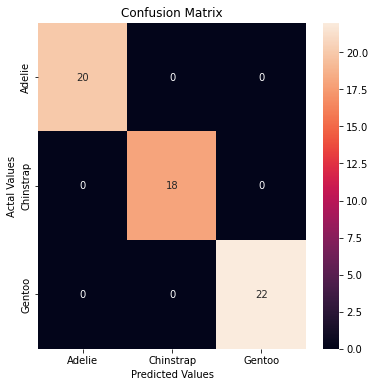

In [35]:
# print("Enter number of hidden layers: ")
# L = int(input())

# print("Enter number of neurons in each hidden layers: ")
# neurons = [5]

# for i in range(L):
#   n = int(input())
#   neurons.append(n)

# neurons.append(3)
# L += 2

# print("Enter learning rate (eta): ")
# Lr = float(input())

# print("Enter number of epochs: ")
# epochs = int(input())

# print("Add bias or not (True=1 / False=0): ")
# bias = int(input())

# print("choose to use (Sigmoid / Tanh) as the activation function: ")
# act_fun = input()

'''
3 - [5,4,3] - True  - "sigmoid" - 0.1 - 500   --> (98)
3 - [5,4,3] - False - "sigmoid" - 0.1 - 500   --> (100)

3 , [5,4,3] , True , "tanh" , 0.01 , 500 --> (98)
3 , [5,4,3] , False , "tanh" , 0.01 , 500 --> (100)
'''
# p = MLP(L, neurons, bias, act_fun, Lr, epochs)

p = MLP(3 , [5,4,3] , 0 , "tanh" , 0.01 , 500)
p.fit(X_train,Y_train)
predictions = p.predict(X_test)

y = Y_test.to_numpy()
predictions = np.array(predictions)
print("***************************************************")
print(f"Accuracy: {accuracy(y,predictions)}")
print("***************************************************")

y_t = np.apply_along_axis(arg_max_value_func, 1, y)
p_t = np.apply_along_axis(arg_max_value_func, 1, predictions)

ConfusionMatrix(y_t, p_t, 'Adelie','Chinstrap','Gentoo')